<a href="https://colab.research.google.com/github/MarceloPiemonteRibeiro/learning-Machine-learning/blob/main/Optimization/Choosing_parameters_to_optimize_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: [Allura course](https://cursos.alura.com.br/course/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros) about ML, overfit and hiper parameters

# Data and models perfomed in the notebook Cross_Validation_Optimization

In [45]:
!pip install graphviz==0.9
!pip install pydot

!apt-get install grapviz
!pip install seaborn==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package grapviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


import data

In [46]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Sort data ascendent - this would affect the model if nothing is done

In [47]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


Use dummy classifier to perform a baseline. It uses the proportion of 0 and 1 to guess. Below also cross_validate was used

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy with dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy with dummy stratified, 10 = [58.00, 58.00]


Use a decision tree also as a second baseline

In [49]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy with cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy with cross validation, 10 = [73.83, 77.73]


Add a column indicating the cars' models (could be an extra column indicating the cars' cluster). This extra column is a categorical variable.

In [50]:
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


This extra column was not used as an X (input, feature) variable to predict but used to group the data, so to prepare the algorithm to new data

Function below to summarize performance

In [51]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy avg %.2f" % media)
  print("Interval [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Create group Kfold that groups the data by the cars' model (created above)

Instead of decision tree classifier algorithm, use SVC algorithm

In [52]:
# GroupKFold in StandardScaler and SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 76.68
Interval [74.28, 79.08]


Use Decision tree classifier now

In [53]:
# GroupKFold now 

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 75.78
Interval [73.67, 77.90]


Visualize

We fitted above 10 models, to visualize which one we want to use? None of them. We trained 10 times to see how good it would behave in the real world. Now, to really use it we need to train it with our X and Y train and test, so add the line modelo.fit(x_azar, y_azar) in the chunk below

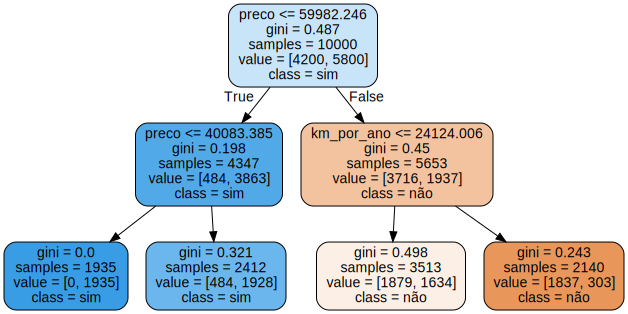

In [54]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

You can increase the Decision tree depth to 3 for example

In [55]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 78.67
Interval [76.40, 80.94]


See that the accuracy is better when using depth=3

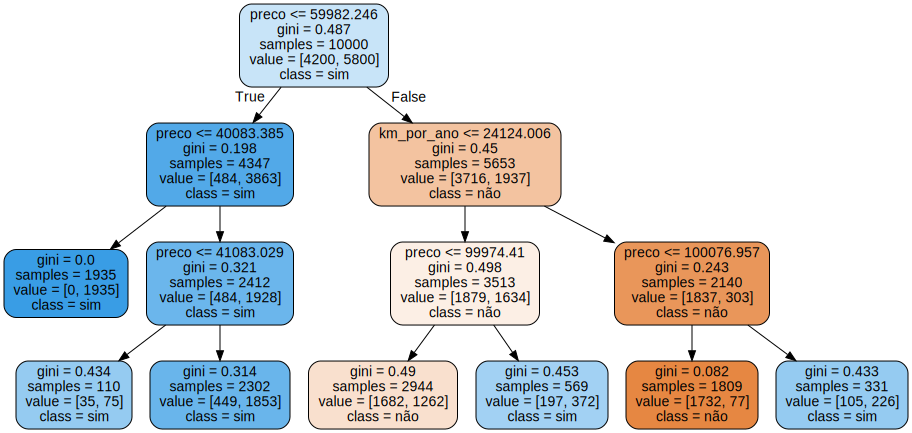

In [56]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

How about using depth=10?

In [57]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 77.19
Interval [75.26, 79.13]


Not necessarily a higher depth reflects a better accuracy, with depth=10 worst accuracy.

# How we choose the algorithms parameters (e.g., depth from tree classifier) to optimize our estimators?

Hyper-parameters are those parameters we choose (e.g., set depth=3 in our decision tree classifier) before trainning (running) the model.

## Testing parameters

Instead of choosing your max_depth you can test in your algorithm all different parameters.

In [58]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth): # define a function to perform our decision tree model
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  print("max_depth = %d, mean =%.2f" % (max_depth, results['test_score'].mean() * 100)) # if you exclude this line you will have more than the mean

for i in range (1, 33): # run the algorithm using max_depth =1 to =33
      roda_arvore_de_decisao(i)

max_depth = 1, mean =75.78
max_depth = 2, mean =75.78
max_depth = 3, mean =78.67
max_depth = 4, mean =78.63
max_depth = 5, mean =78.56
max_depth = 6, mean =78.12
max_depth = 7, mean =77.96
max_depth = 8, mean =77.86
max_depth = 9, mean =77.38
max_depth = 10, mean =77.19
max_depth = 11, mean =76.97
max_depth = 12, mean =76.49
max_depth = 13, mean =75.81
max_depth = 14, mean =75.66
max_depth = 15, mean =75.16
max_depth = 16, mean =75.11
max_depth = 17, mean =74.74
max_depth = 18, mean =74.33
max_depth = 19, mean =74.34
max_depth = 20, mean =74.22
max_depth = 21, mean =73.80
max_depth = 22, mean =73.81
max_depth = 23, mean =73.38
max_depth = 24, mean =73.43
max_depth = 25, mean =73.14
max_depth = 26, mean =73.04
max_depth = 27, mean =72.91
max_depth = 28, mean =72.66
max_depth = 29, mean =72.73
max_depth = 30, mean =72.81
max_depth = 31, mean =72.86
max_depth = 32, mean =72.52


See that with a higher max_depth the performance wasn't better. 

The above code run the algorithm in our test data. A decision tree with a high max_depth becomes very attached to the train dataset and performs worst when new data is introduced (when model is ran in the test data). Attached in the sense that it captures all the specificities of the train data but becomes rigid and cannot adapt and interpret well new data (our test). 

See that this is happening below, with the algorithm getting better and better when fitted to the train data but not to the test data.

In [59]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  print("Arvore max_depth = %d, fitted to train data = %.2f, fitted to test data = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))



for i in range (1, 33):
      roda_arvore_de_decisao(i)

Arvore max_depth = 1, fitted to train data = 75.79, fitted to test data = 75.78,
Arvore max_depth = 2, fitted to train data = 75.79, fitted to test data = 75.78,
Arvore max_depth = 3, fitted to train data = 78.75, fitted to test data = 78.67,
Arvore max_depth = 4, fitted to train data = 78.79, fitted to test data = 78.63,
Arvore max_depth = 5, fitted to train data = 78.94, fitted to test data = 78.56,
Arvore max_depth = 6, fitted to train data = 79.17, fitted to test data = 78.12,
Arvore max_depth = 7, fitted to train data = 79.50, fitted to test data = 77.96,
Arvore max_depth = 8, fitted to train data = 79.89, fitted to test data = 77.86,
Arvore max_depth = 9, fitted to train data = 80.46, fitted to test data = 77.38,
Arvore max_depth = 10, fitted to train data = 81.16, fitted to test data = 77.19,
Arvore max_depth = 11, fitted to train data = 82.03, fitted to test data = 76.97,
Arvore max_depth = 12, fitted to train data = 82.89, fitted to test data = 76.49,
Arvore max_depth = 13, fi

See that the algorithm gets better with higher max_depth only when fitted to the train data.

Visualize better

In [60]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)] # it rund the function for each i and returns the table
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"]) # transform in a data frame
resultados.head(33)

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204


Now you can graph your dataframe above: see that you have overfit in the train data (blue line) but the opposite in the test data

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


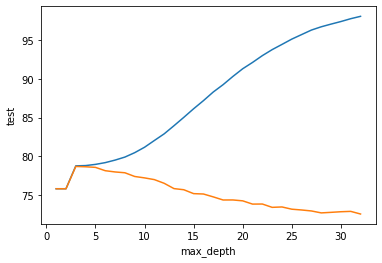

In [61]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)

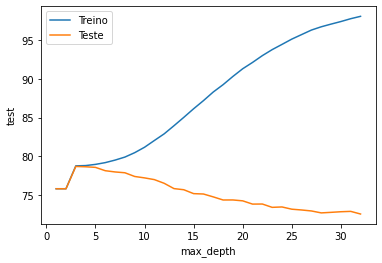

In [62]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

Our best decision trees are:

In [63]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
